<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2025/blob/main/DL_day16/16_1_NBEATS_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with N-Beats


In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Practice: Renewable Energy Forecasting
- Hourly dataset: Energy consumption in Romania
- Data Source: https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production

In [ ]:
!pip install neuralforecast
!pip install lightning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import lightning.pytorch as pl
import neuralforecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MAE

import os

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/SLCFLAB/Fintech2025/refs/heads/main/DL_day16/data/electricityConsumptionAndProductioction.csv', parse_dates=['DateTime'])
df.drop_duplicates(inplace=True)
df

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
...,...,...,...,...,...,...,...,...,...,...
46006,2024-03-31 19:00:00,5618,5902,1398,505,2294,1012,620,6,65
46007,2024-03-31 20:00:00,6107,6205,1395,671,2389,1037,645,0,66
46008,2024-03-31 21:00:00,5991,5855,1395,868,2201,705,621,0,66
46009,2024-03-31 22:00:00,5527,5726,1393,908,2088,648,622,0,66


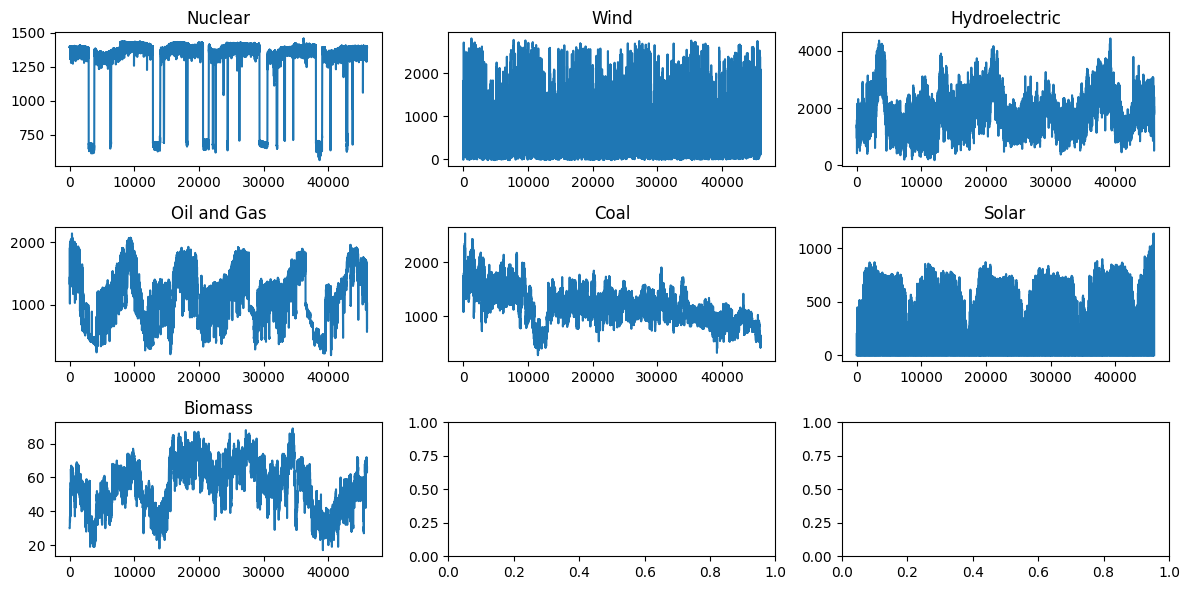

In [ ]:
_, ax = plt.subplots(3, 3, tight_layout=True, figsize=(12,6))
for i, a in zip(np.arange(3, 10), ax.flat):
    a.plot(df.iloc[:, i])
    a.set_title(df.columns[i]);

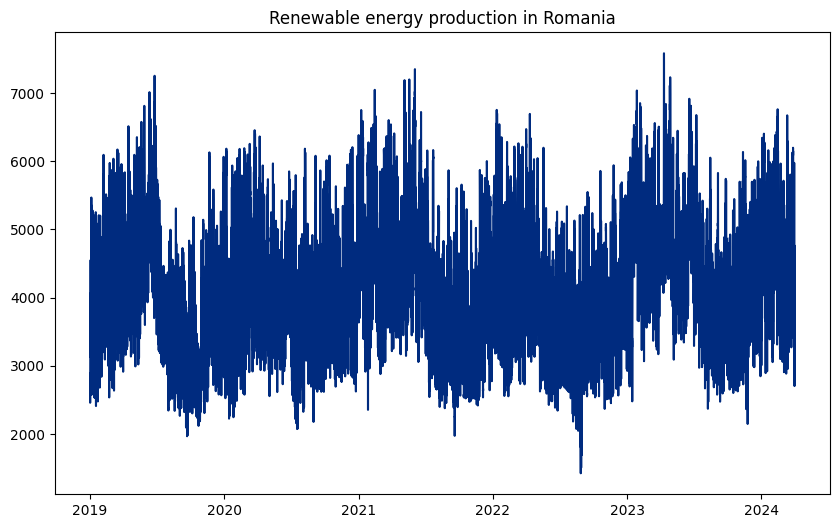

In [ ]:
df['Renewable'] = df['Production'] - df['Coal'] - df['Oil and Gas']

plt.figure(figsize=(10, 6))
plt.plot(df.DateTime, df.Renewable, color='#002B7F')
plt.title('Renewable energy production in Romania');

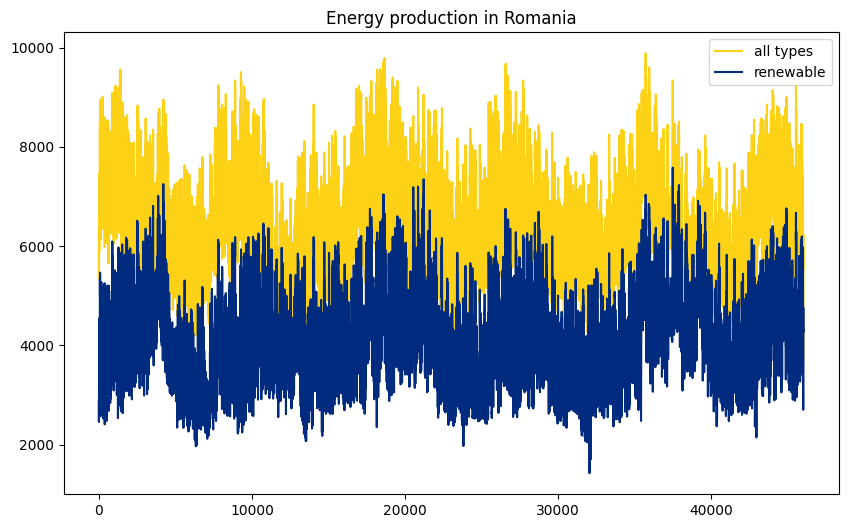

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.Production, color='#FCD116', label='all types')
plt.plot(df.Renewable, color='#002B7F', label='renewable')
plt.legend()
plt.title('Energy production in Romania');

In [ ]:
df['unique_id'] = df.DateTime.dt.year
df = df.loc[df.unique_id!=2024, ['DateTime', 'unique_id', 'Renewable']]
df['Renewable'] = df.Renewable.astype('float32')
df

,DateTime,unique_id,Renewable
0,2019-01-01 00:00:00,2019,2887.0
1,2019-01-01 01:00:00,2019,2631.0
2,2019-01-01 02:00:00,2019,2595.0
3,2019-01-01 03:00:00,2019,2590.0
4,2019-01-01 04:00:00,2019,2542.0
...,...,...,...
43823,2023-12-31 19:00:00,2023,4753.0
43824,2023-12-31 20:00:00,2023,4776.0
43825,2023-12-31 21:00:00,2023,4909.0
43826,2023-12-31 22:00:00,2023,4187.0


In [ ]:
df.rename({'Renewable': 'y', 'DateTime': 'ds'}, axis='columns', inplace=True)
df

,ds,unique_id,y
0,2019-01-01 00:00:00,2019,2887.0
1,2019-01-01 01:00:00,2019,2631.0
2,2019-01-01 02:00:00,2019,2595.0
3,2019-01-01 03:00:00,2019,2590.0
4,2019-01-01 04:00:00,2019,2542.0
...,...,...,...
43823,2023-12-31 19:00:00,2023,4753.0
43824,2023-12-31 20:00:00,2023,4776.0
43825,2023-12-31 21:00:00,2023,4909.0
43826,2023-12-31 22:00:00,2023,4187.0


In [ ]:
OUR_HORIZON = 24*30*3

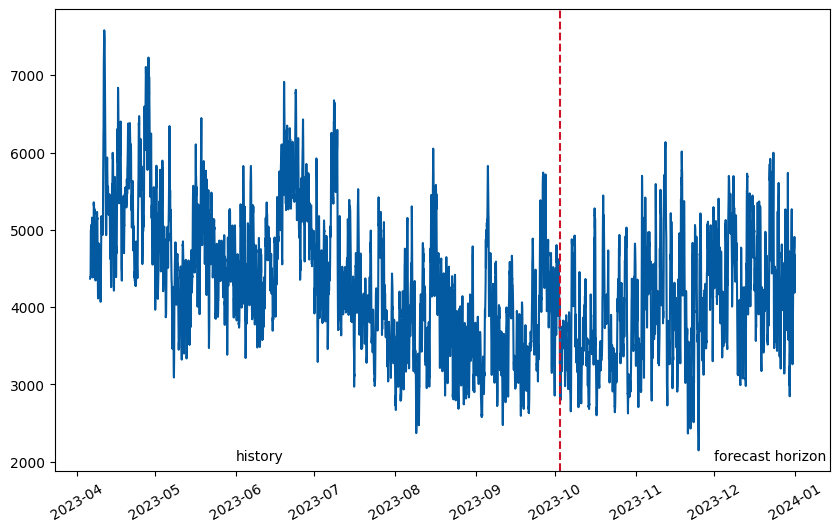

In [ ]:
train = df.iloc[:-(3*OUR_HORIZON), :]
test = df.iloc[-(3*OUR_HORIZON):, :]

plt.figure(figsize=(10, 6))
plt.plot(test.ds, test.y, color='#045AA0')
plt.axvline(test.ds.iloc[-OUR_HORIZON], linestyle='--', color='#CE1126')
plt.text(x=pd.to_datetime('2023-06-01'), y=2024, s='history')
plt.text(x=pd.to_datetime('2023-12-01'), y=2024, s='forecast horizon')
plt.tick_params(axis='x', rotation=30);

In [ ]:
nbeats = NBEATS(h=OUR_HORIZON, input_size=3*OUR_HORIZON, n_harmonics=2, n_polynomials=2,
                valid_loss=MAE(), max_steps=10, n_blocks=[2,2,1],
                batch_size=256, start_padding_enabled=True)
fcst = neuralforecast.NeuralForecast([nbeats], freq='h')

#max_steps 300

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
fcst.fit(train, val_size=OUR_HORIZON)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | valid_loss   | MAE           | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 71.2 M | train
-------------------------------------------------------
33.8 M    Trainable params
37.4 M    Non-trainable params
71.2 M    Total params
284.766   Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.


In [ ]:
electricity_forecast = fcst.predict(test)
electricity_forecast

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,NBEATS
0,2023,2024-01-01 00:00:00,2699.935791
1,2023,2024-01-01 01:00:00,-227.279419
2,2023,2024-01-01 02:00:00,2023.607910
3,2023,2024-01-01 03:00:00,-5530.615234
4,2023,2024-01-01 04:00:00,6457.578613
...,...,...,...
2155,2023,2024-03-30 19:00:00,-174.841553
2156,2023,2024-03-30 20:00:00,536.723633
2157,2023,2024-03-30 21:00:00,9027.548828
2158,2023,2024-03-30 22:00:00,-3443.098145


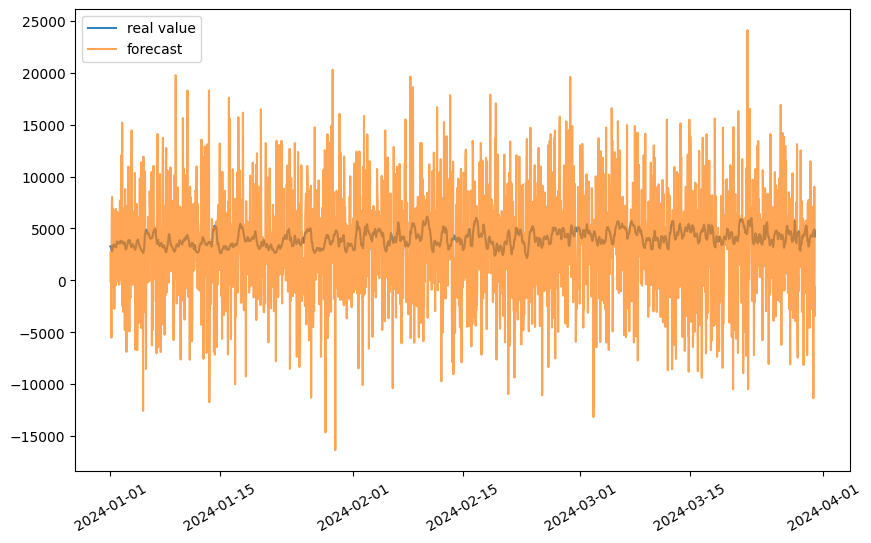

In [ ]:
daterange = electricity_forecast.ds
plt.figure(figsize=(10, 6))
plt.plot(daterange, test.y.iloc[-OUR_HORIZON:], label='real value', alpha=0.9)
plt.plot(daterange, electricity_forecast.NBEATS, label='forecast', alpha=0.7)
plt.tick_params(axis='x', rotation=30)
plt.legend()
plt.show()

In [ ]:
calculate_mae = MAE()
calculate_mae.__call__(y=torch.tensor(test.y.iloc[-OUR_HORIZON:].to_numpy()),
                       y_hat=torch.tensor(electricity_forecast.NBEATS.to_numpy()))

tensor(4192.7153)

## Another example

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 2.4 M  | train
----------------------------------------------------------
2.4 M     Trainable params
905       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[]

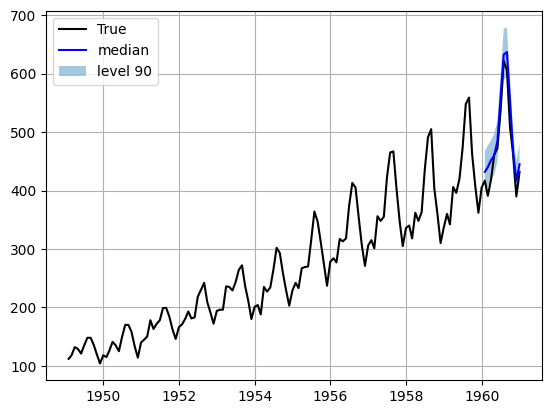

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NBEATS(h=12, input_size=24,
               loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
               stack_types = ['identity', 'trend', 'seasonality'],
               max_steps=100,
               val_check_steps=10,
               early_stop_patience_steps=2)

fcst = NeuralForecast(
    models=[model],
    freq='ME'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['NBEATS-lo-90'][-12:].values,
                 y2=plot_df['NBEATS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()

> **Note:**  
> If you want to visualize components like trend and seasonality from N-BEATS, consider using `pytorch-forecasting`.  
> However, support for this is version-dependent and may require code modifications. Use with caution.
